# Assignment2 - Supervised Learning flow

# Part 1(a) Student details:
* Please write the First-Name, First letter of Last-Name and last 4 digits of the i.d. for each student. 

In [27]:
# stundent details:
# Michael O J 5140
# Agam M 6895
# Ofek L 8567

## Part 1(b) - Chat-GPT/other AI-agent/other assistance used:
* If you changed the prompt until you got a satisfying answer, please add all versions
* don't delete "pre" tags, so new-line is supported
* double click the following markdown cell to change
* press shift+enter to view
* Add information:

    #### Add information in this Markdown cell (double click to change, shift-enter to view)
<pre>   
AI agent name: Coplilot-{Gpt, Claude, etc...}
Goal: Help us write proper code, prevent errors and to understand the pipeline better.
Propmpt1:
    "Fix the highlighted code"
Propmpt2:
    "Why do i get this error?"
Propmpt3:
    "Explain hyperparameters and their importance in ML"


AI agent name 2:
Goal:
Propmpt1:

Propmpt2:

Propmpt3:


Other assistanse:
</pre>

    ## Part 1(c) - Learning Problem and dataset explaination.
* Please explain in one paragraph
* don't delete "pre" tags, so new-line is supported
* double click the following markdown cell to change
* press shift+enter to view
* Add explaining text:

    #### Add information in this Markdown cell (double click to change, shift-enter to view)
<pre>
The learning problem involves predicting the median house value (`MedHouseVal`) based on various features such as the average number of rooms (`AveRooms`), population size (`Population`), and other housing-related attributes. The dataset used for this task is a housing dataset split into training (`housing_train.csv`) and test (`housing_test.csv`) sets. The training set is used to build and optimize machine learning models, while the test set is used to evaluate the model's performance. The goal is to identify the best combination of feature engineering techniques and algorithms to achieve accurate predictions of house prices.
</pre>

## Part 2 - Initial Preparations 
You could add as many code cells as needed

In [28]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
from seaborn import heatmap

from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.pipeline import Pipeline

In [29]:
df_train = pd.read_csv("housing_train.csv")
df_test = pd.read_csv("housing_test.csv")

In [30]:
df_train.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,4.0179,46.0,4.158690,1.032746,512.0,1.289673,34.07,-118.35,3.500
1,2.7002,6.0,4.149245,1.179989,4092.0,2.287311,34.05,-117.31,0.883
2,1.2762,17.0,3.432331,1.022556,1325.0,2.490602,34.42,-119.69,2.536
3,4.9342,23.0,5.735798,1.053201,4580.0,4.129847,34.04,-117.93,1.810
4,2.2755,21.0,4.064607,0.962079,2109.0,2.962079,32.58,-117.11,1.250


In [31]:
df_test.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,5.3254,32.0,5.786260,1.033079,982.0,2.498728,34.29,-119.27,3.852
1,5.3032,52.0,5.095745,1.028369,980.0,3.475177,34.08,-118.12,2.457
2,4.1679,41.0,6.617486,1.371585,915.0,2.500000,37.05,-122.05,2.013
3,3.6429,28.0,5.249180,1.009836,848.0,2.780328,38.69,-121.41,1.052
4,2.7457,17.0,11.183267,2.107570,675.0,2.689243,38.88,-119.99,1.078


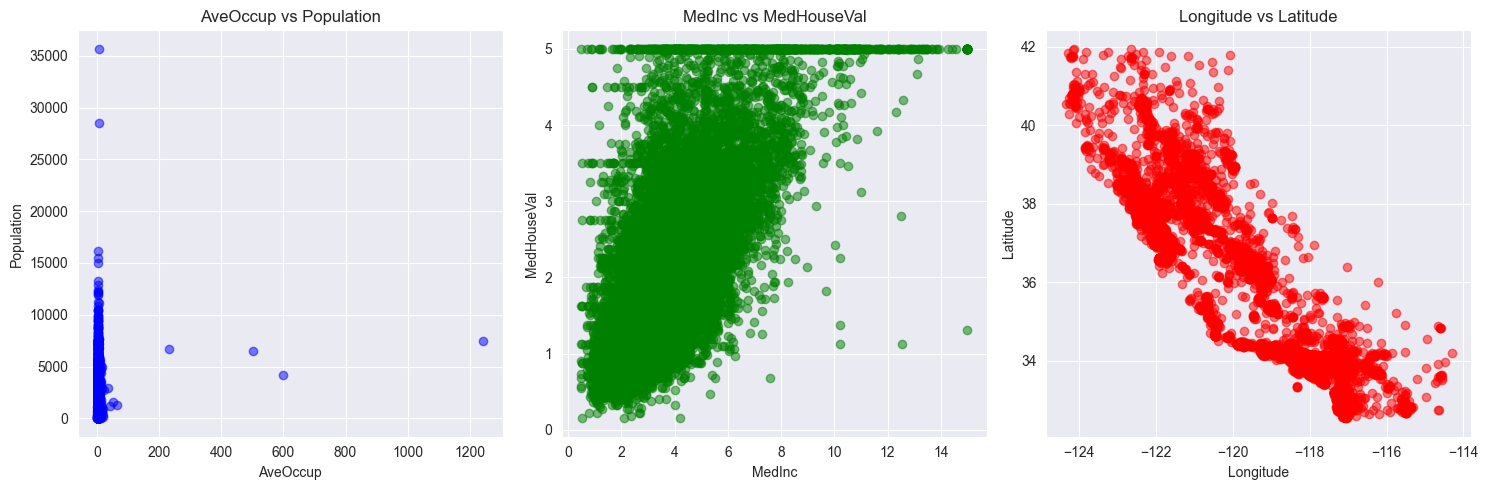

In [32]:
figure, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].scatter(df_train['AveOccup'], df_train['Population'], alpha=0.5, color='blue')
axes[0].set_xlabel('AveOccup')
axes[0].set_ylabel('Population')
axes[0].set_title('AveOccup vs Population')

axes[1].scatter(df_train['MedInc'], df_train['MedHouseVal'], alpha=0.5, color='green')
axes[1].set_xlabel('MedInc')
axes[1].set_ylabel('MedHouseVal')
axes[1].set_title('MedInc vs MedHouseVal')

axes[2].scatter(df_train['Longitude'], df_train['Latitude'], alpha=0.5, color='red')
axes[2].set_xlabel('Longitude')
axes[2].set_ylabel('Latitude')
axes[2].set_title('Longitude vs Latitude')

plt.tight_layout()
plt.show()

In [33]:
# data cleansing
def clean_data(df):
    df.dropna(inplace=True)
    df.drop_duplicates(inplace=True)
    return df

def remove_outliers(df, column, threshold=3):
    mean = df[column].mean()
    std_dev = df[column].std()
    lower_bound = mean - threshold * std_dev
    upper_bound = mean + threshold * std_dev
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

In [34]:
print(f"Train set shape before cleaning: {df_train.shape}")

df_train = clean_data(df_train)
for column in df_train.columns:
    df_train = remove_outliers(df_train, column)

print(f"Train set shape after cleaning: {df_train.shape}")

Train set shape before cleaning: (16512, 9)
Train set shape after cleaning: (15568, 9)


Latitude and Longitude: correlation = -0.93
Longitude and Latitude: correlation = -0.93


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
MedInc,1.000000,-0.147706,0.690584,-0.214160,-0.010197,-0.094939,-0.080839,-0.014441,0.657415
HouseAge,-0.147706,1.000000,-0.212243,-0.104081,-0.305395,-0.014972,0.008354,-0.096066,0.112330
AveRooms,0.690584,-0.212243,1.000000,0.113693,-0.070200,-0.041097,0.125290,-0.089265,0.293545
AveBedrms,-0.214160,-0.104081,0.113693,1.000000,0.028247,-0.086621,0.052950,-0.005585,-0.067769
Population,-0.010197,-0.305395,-0.070200,0.028247,1.000000,0.189323,-0.105805,0.099175,-0.035496
AveOccup,-0.094939,-0.014972,-0.041097,-0.086621,0.189323,1.000000,-0.143514,0.159357,-0.278233
Latitude,-0.080839,0.008354,0.125290,0.052950,-0.105805,-0.143514,1.000000,-0.931276,-0.144782
Longitude,-0.014441,-0.096066,-0.089265,-0.005585,0.099175,0.159357,-0.931276,1.000000,-0.042703
MedHouseVal,0.657415,0.112330,0.293545,-0.067769,-0.035496,-0.278233,-0.144782,-0.042703,1.000000


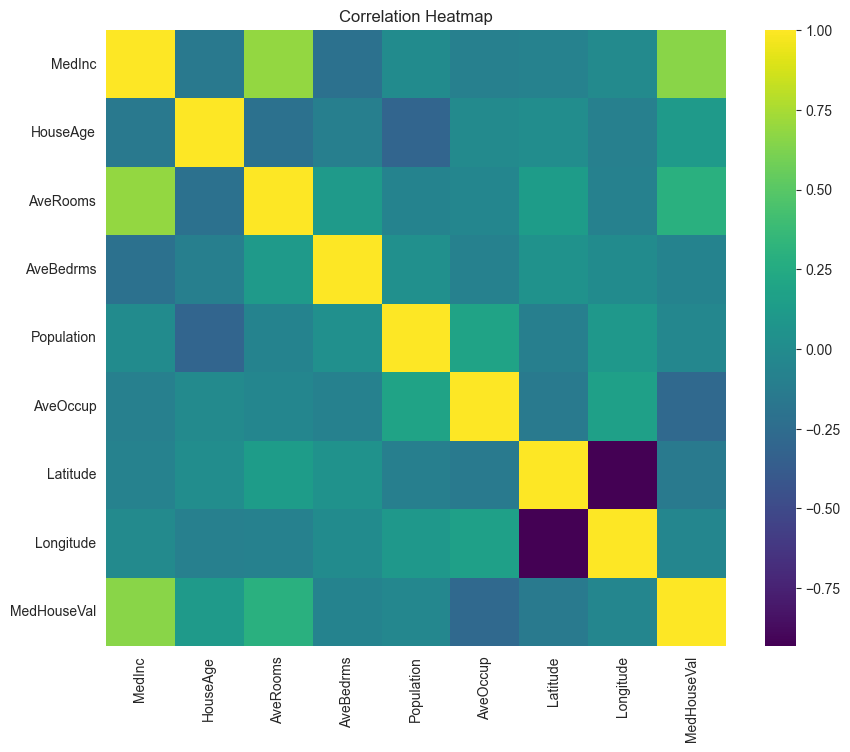

In [35]:
corr = df_train.corr(method = 'pearson')

high_corr = np.where((np.abs(corr) > 0.7) & (np.abs(corr) < 1.0))
high_corr_pairs = [(corr.index[x], corr.columns[y], corr.iloc[x, y]) for x, y in zip(*high_corr)]

for col1, col2, value in high_corr_pairs:
    print(f"{col1} and {col2}: correlation = {value:.2f}")

display(corr)

figure, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr, fmt=".2f", cmap='viridis', ax=ax)
plt.title('Correlation Heatmap')
plt.show()

In [36]:
# dimension reduction
# We will drop the 'MedInc' column as it is highly correlated with 'MedHouseVal'
df_train.drop(columns=['MedInc'], inplace=True)
df_test.drop(columns=['MedInc'], inplace=True)
#
# # # We will drop the 'Longitude' and 'Latitude' columns as they are not relevant for our analysis
# df_train.drop(columns=['Longitude', 'Latitude'], inplace=True)
# df_test.drop(columns=['Longitude', 'Latitude'], inplace=True)

# We will drop the 'AveOccup' column as it is highly correlated with 'Population'
# df_train.drop(columns=['AveOccup'], inplace=True)
# df_test.drop(columns=['AveOccup'], inplace=True)

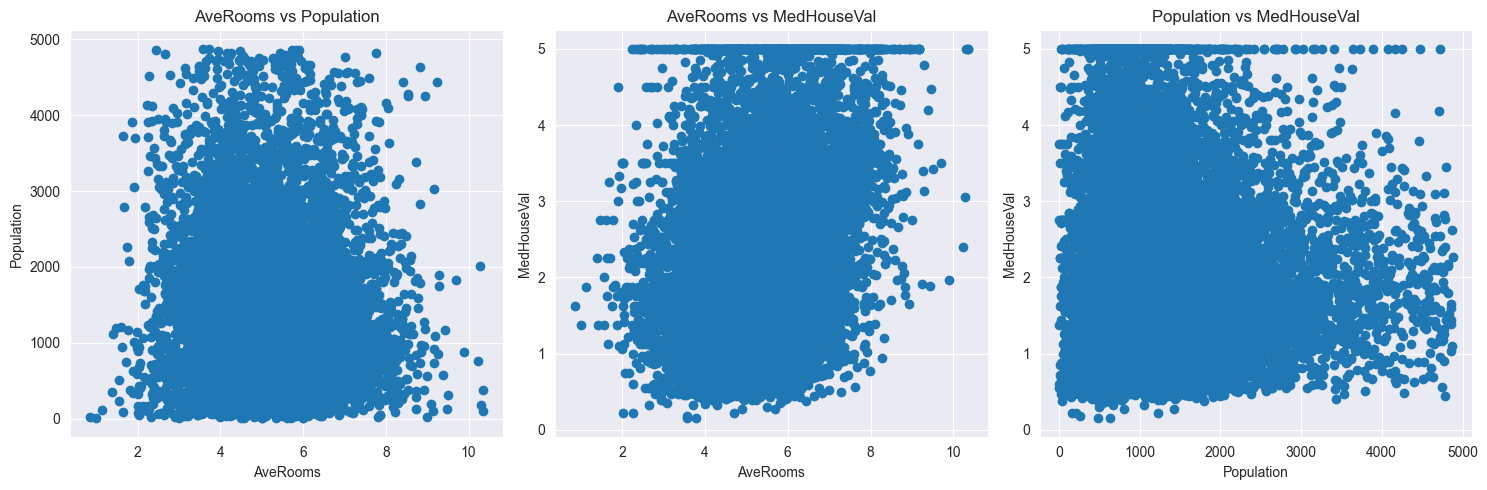

In [37]:
figure, axes = plt.subplots(1, 3, figsize=(15, 5))

col1, col2, col3 = "AveRooms", "Population", "MedHouseVal"

axes[0].scatter(df_train[col1], df_train[col2])
axes[0].set_xlabel(col1)
axes[0].set_ylabel(col2)
axes[0].set_title(f'{col1} vs {col2}')

axes[1].scatter(df_train[col1], df_train[col3])
axes[1].set_xlabel(col1)
axes[1].set_ylabel(col3)
axes[1].set_title(f'{col1} vs {col3}')

axes[2].scatter(df_train[col2], df_train[col3])
axes[2].set_xlabel(col2)
axes[2].set_ylabel(col3)
axes[2].set_title(f'{col2} vs {col3}')

plt.tight_layout()
plt.show()

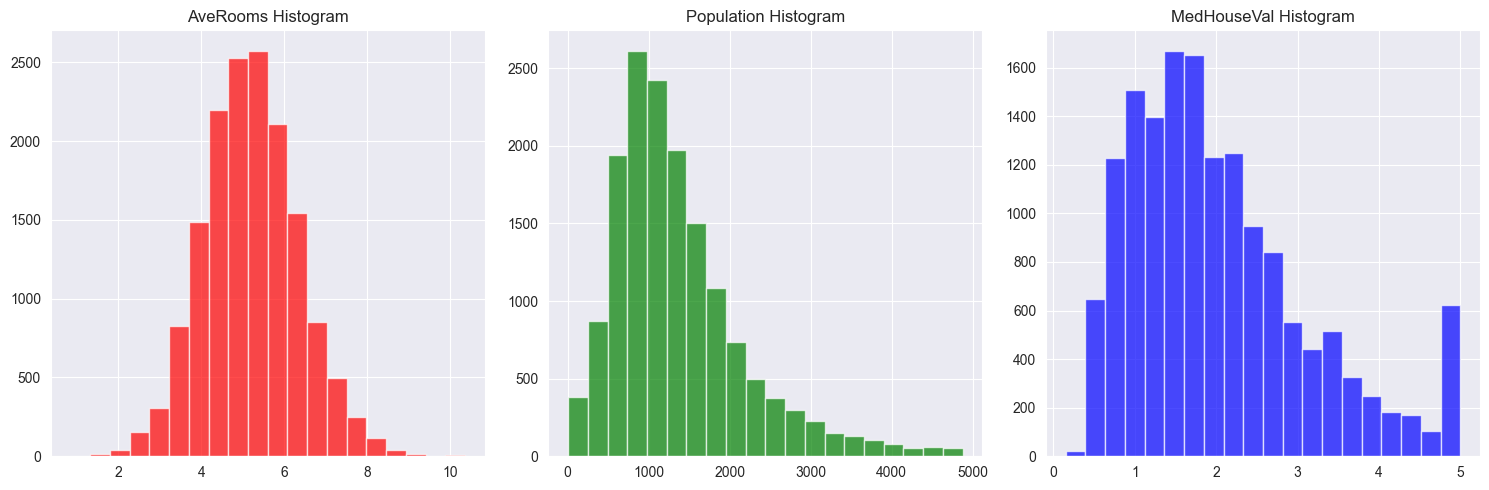

In [38]:
figure , axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].hist(df_train[col1], bins=20, color='red', alpha=0.7)
axes[0].set_title(f'{col1} Histogram')

axes[1].hist(df_train[col2], bins=20, color='green', alpha=0.7)
axes[1].set_title(f'{col2} Histogram')

axes[2].hist(df_train[col3], bins=20, color='blue', alpha=0.7)
axes[2].set_title(f'{col3} Histogram')

plt.tight_layout()
plt.show()

The purpose of the visualizations is to explore the relationships and distributions of key features in the dataset. Scatter plots are used to examine potential correlations between variables (such as average rooms, population, and median house value), while histograms provide insights into the distribution of each feature, helping to identify patterns, outliers, or skewness in the data.

## Part 3 - Experiments
You could add as many code cells as needed

In [39]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNet

# Feature engineering options
feature_options = [
    [],  # No transformation
    ['scale'],  # Standard scaling
    ['poly2'],  # Polynomial degree 2
    ['selectk'],  # Feature selection
    ['scale', 'poly2'],  # Scaling + Polynomial
    ['scale', 'selectk'],  # Scaling + Feature selection
    ['poly2', 'selectk'],  # Polynomial + Feature selection
    ['scale', 'poly2', 'selectk']  # All transformations
]

# Models and their hyperparameters
models = {
    'LinearRegression': {
        'model': LinearRegression(),
        'params': {}
    },
    'RandomForest': {
        'model': RandomForestRegressor(random_state=42),
        'params': {'model__n_estimators': [50, 100], 'model__max_depth': [3, 5, None]}
    },
    'Ridge': {
        'model': Ridge(),
        'params': {'model__alpha': [0.1, 1, 10]}
    },
    'NeuralNetwork': {
        'model': MLPRegressor(random_state=42, max_iter=500),
        'params': {'model__hidden_layer_sizes': [(50,), (100,)], 'model__activation': ['relu', 'tanh']}
    },
    'XGBoost': {
        'model': XGBRegressor(tree_method='hist', device='cuda', random_state=42),
        'params': {'model__n_estimators': [50, 100], 'model__max_depth': [3, 5, None]}
    }
}
results = []

X = df_train.drop('MedHouseVal', axis=1)
y = df_train['MedHouseVal']

In [ ]:
for feats in feature_options:
    start_time = time.time()
    steps = []
    feats_name = []
    if 'scale' in feats:
        steps.append(('scaler', StandardScaler()))
        feats_name.append('scale')
    if 'poly2' in feats:
        steps.append(('poly', PolynomialFeatures(degree=2, include_bias=False)))
        feats_name.append('poly2')
    if 'selectk' in feats:
        steps.append(('selectk', SelectKBest(score_func=f_regression, k=2)))
        feats_name.append('selectk')
    for model_name, model_dict in models.items():
        print(f"Running model: {model_name} with features: {feats_name}")

        pipe_steps = steps + [('model', model_dict['model'])]
        pipe = Pipeline(pipe_steps)
        param_grid = model_dict['params']

        grid = GridSearchCV(pipe, param_grid, cv=5, scoring=make_scorer(mean_squared_error, greater_is_better=False), n_jobs=-1)
        grid.fit(X, y)

        elapsed_time = time.time() - start_time
        results.append({
            'Feature Engineering': '+'.join(feats_name) if feats_name else 'none',
            'Model': model_name,
            'Best Params': grid.best_params_,
            'CV Mean MSE': -grid.best_score_,
            'R² Score':  grid.best_estimator_.score(X, y),
            'Elapsed Time (s)': elapsed_time
        })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values('R² Score', ascending=False)
display(results_df)

Running model: LinearRegression with features: []
Running model: RandomForest with features: []
Running model: Ridge with features: []
Running model: NeuralNetwork with features: []
Running model: XGBoost with features: []


## Part 4 - Training 
Use the best combination of feature engineering, model (algorithm and hyperparameters) from the experiment part (part 3)

In [21]:
best_result = results_df.iloc[0]
best_features = best_result['Feature Engineering'].split('+') if best_result['Feature Engineering'] != 'none' else []
best_model_name = best_result['Model']
best_params = {k: v for k, v in best_result['Best Params'].items() if k != 'model__model'}

steps = []
if 'scale' in best_features:
    steps.append(('scaler', StandardScaler()))
if 'poly2' in best_features:
    steps.append(('poly', PolynomialFeatures(degree=2, include_bias=False)))
if 'selectk' in best_features:
    steps.append(('selectk', SelectKBest(score_func=f_regression, k=2)))

best_model = models[best_model_name]['model']
steps.append(('model', best_model))

pipeline = Pipeline(steps)

pipeline.set_params(**best_params)

pipeline.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', RandomForestRegressor(random_state=42))])

## Part 5 - Apply on test and show model performance estimation

In [22]:
X_test = df_test.drop('MedHouseVal', axis=1)
y_test = df_test['MedHouseVal']

y_pred = pipeline.predict(X_test)

cv_scores = cross_val_score(pipeline, X_test, y_test, cv=5, scoring=make_scorer(mean_squared_error, greater_is_better=False))
mean_cv_mse = -cv_scores.mean()
score = pipeline.score(X_test, y_test)

print(f"Cross-Validation Mean MSE on Test Set: {mean_cv_mse}")
print(f"R² Score on Test Set: {score}")
print(f"Model Accuracy: {score*100:.2f}%")

pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}).head()

Cross-Validation Mean MSE on Test Set: 0.31987038064899637
R² Score on Test Set: 0.8224217294777335
Model Accuracy: 82.24%


,Actual,Predicted
0,3.852,2.901430
1,2.457,2.058790
2,2.013,3.401662
3,1.052,0.981150
4,1.078,2.267820


Feature Importance:


,Feature,Importance
5,Latitude,0.272809
6,Longitude,0.247072
1,AveRooms,0.201088
4,AveOccup,0.160635
0,HouseAge,0.050541
2,AveBedrms,0.036192
3,Population,0.031664


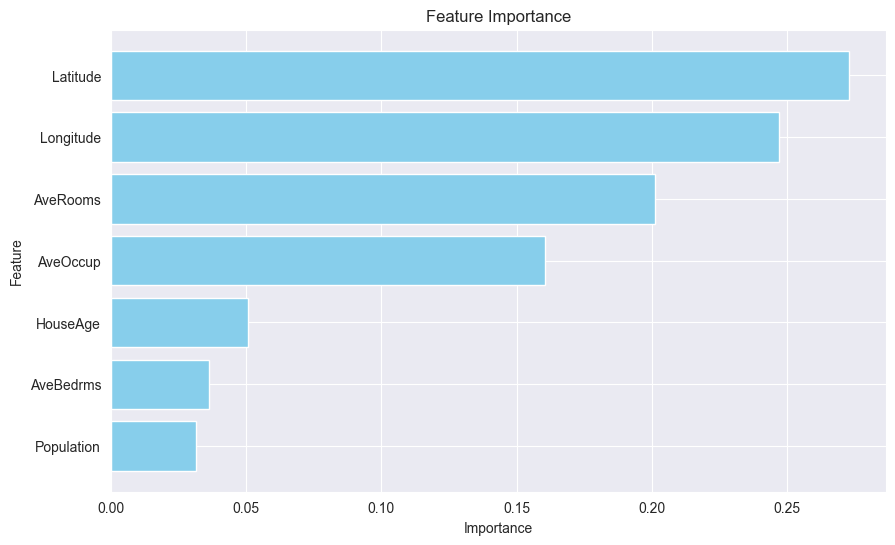

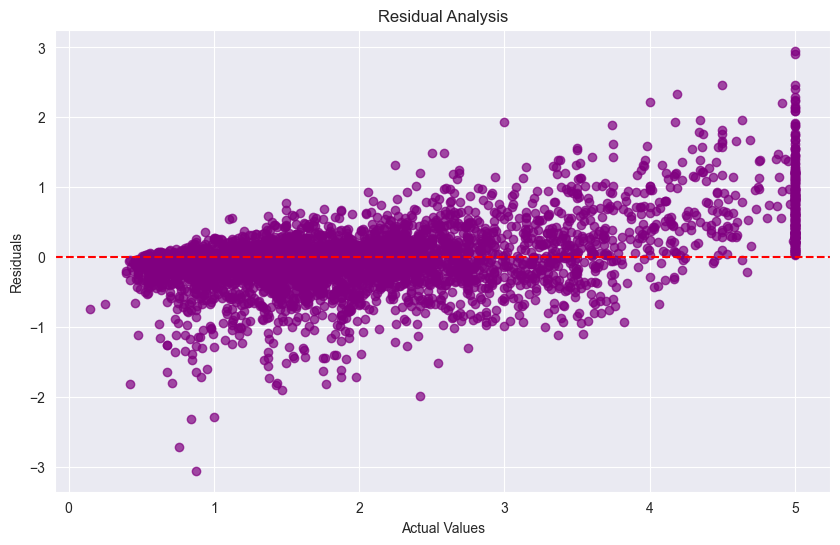

In [17]:
if hasattr(best_model, 'feature_importances_'):
    feature_importance = best_model.feature_importances_
    if 'poly2' in best_features:
        poly = [step for name, step in pipeline.steps if name == 'poly'][0]
        feature_names = poly.get_feature_names_out(X.columns)
    else:
        feature_names = X.columns
    importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    print("Feature Importance:")
    display(importance_df)

    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance')
    plt.gca().invert_yaxis()
    plt.show()

residuals = y_test - y_pred

plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals, alpha=0.7, color='purple')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Actual Values')
plt.ylabel('Residuals')
plt.title('Residual Analysis')
plt.show()